# Analog vs Digital Transmission
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In this notebook we will explore the advantages of digital transmission over analog transmission. We will model the case of transmission over a long (e.g. transoceanic) cable in which several repeaters are used to compensate for the attenuation incurred by the signal.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy.io import wavfile

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

In [3]:
def multiplot(*signals):
    for i, s in enumerate(signals):
        plt.subplot(1, len(signals), i+1)
        plt.plot(s);

## 1. Analog transmission

<img width="550" style="float: left; margin: 0px 20px 0 0;" src="cable.jpg">

When an electrical signal is transmitted over a conductive cable, its power is attenuated in a way that is proportional to the length of the cable and, normally, an amplifier at the receiving end is necessary to compensate for this attenuation.

For standard copper coaxial cables, the attenuation is approximately 1 dB per mile (that is, 1 dB per 1.6 Km) so that after approximately 32Km the power will have fallen by 20dB or, equivalently, the amplitude of the signal will have decreased by 90%. 

Fun fact: the decibel, as a unit of measurement, was in fact *defined* as the expected attenuation induced by one mile of cable!

See [**this Wikipedia entry**](https://en.wikipedia.org/wiki/Decibel) for a review on the decibel system if you are not familiar with this unit of measurement.

When the first transoceanic telephone lines were being designed in the early decades of the 20th century, with a length in excess of 3200Km, it was clear that a single amplifier at the receiving end would not be enough to recover the transmitted signal. The cable therefore was subdivided into a series of 30Km sections, each followed by an underwater *repeating amplifier* designed to compensate for the attenuation introduced by each section.

Unfortunately, however, a transmitted signal is not only attenuated but it is also affected by additive *noise*, which the repeaters amplify as well. If many repeaters are used, the signal to noise ratio at the end of the chain can become too low and the telephone conversation can become unintelligible.

Problem setup:
 * cable is subdivided into 30 km segments, with repeating amplifiers between sections
 * each cable segment attenuates the signal by a factor $1/G$
 * repeater restore the signal's amplitude via a gain factor $G$. 

 
If $x(t)$ is the original signal, the signal at the input of the first repeater will be

$$
    x_{1,i}(t) = (1/G)x(t) + \sigma(t)
$$

where $\sigma(t)$ is the noise picked up in the first segment. 

After the repeater the signal will be 

$$
    x_{1,o}(t) = Gx_{1,i}(t) = x(t) + G\sigma(t)
$$

so that the noise will be $G$ times larger. 

At the end of a chain of $N$ repeaters, assuming that the noise is statistically independent, the signal will be approximately equal to

$$
    \hat{x}_N(t)  = x(t) + NG\sigma(t).
$$

<img width="650" src="chain.jpg">

## 2. Digital encoding

Assume that what we want to transmit is an analog audio signal $x(t)$, with amplitude between $-1$ and $+1$ mV. 

For analog transmission, we would simply put the signal directly on the transmission line. In this case the instantaneous amplitude of the analog signal can take any value in the interval $[-1, 1]$

For digital transmission, we do the following:
 1. we sample the analog signal into a discrete-time sequence $x[n]$
 1. we map (quantize) the samples to a predefined set of values $Q$
 1. we build an analog signal $x_d(t)$ that is piecewise constant between quantized values
 1. we transmit $x_d(t)$

 
If the sampling is done properly, no quality is lost but quantization will reduce the quality as we will show presently. The idea is that we will be willing to accept this quality loss because it will result in a signal that is more robust to transmission over long cables.

First let's define a quantization function that maps input values in $[-1, 1]$ onto a finite set of $2M+1$ values, with $M$ an integer of our choice. To do this, we first rescale the input to the $[-M, M]$ interval and then we drop the fractional part: the input is now mapped onto one of the *integers* between $-M$ and $M$; finally, we divide the result by $M$ to bring back the quantized signal to its original range.

In [4]:
def quantize(x, M):
    return np.round(x * M) / M

The quantization maps the input to the set $Q = \{-\frac{M}{2M+1}, -\frac{M-1}{2M+1}, \ldots, -\frac{1}{2M+1}, 0, \frac{1}{2M+1}, \ldots, \frac{M-1}{2M+1}, \frac{M}{2M+1}\}$, which contains $2M+1$ possible integer values. Both analog and digital signals have the same range and we can compare them visually: 

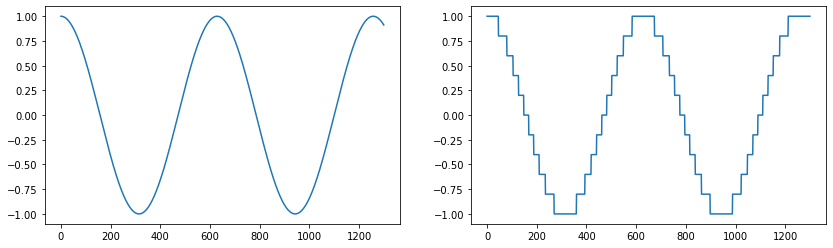

In [5]:
# the original signal between -1 and 1
x = np.cos(np.arange(0, 13, 0.01))
multiplot(x, quantize(x, 5))

Obviously the quantized signal is distorted with respect to the smooth original. To quantify this distortion we can compute the so-called **Signal to Noise Ratio** (SNR); this is the power of the original signal divided by the power of the error introduced by quantization and it is usually expressed on a logarithmic scale in decibels (dB)

In [6]:
def SNR(original, distorted):
    # power of the error
    err = np.sum((original - distorted) ** 2)
    # power of the signal
    sig = np.sum(original ** 2)
    # SNR in dBs
    return 10 * np.log10(sig / err)

In [7]:
SNR(x, quantize(x, 5))

22.437782203667474

Clearly, quantization over 11 possible level (for $M=5$) leads to a rather low SNR; in practical applications we would use at least 8 bits per sample, which provides a higher SNR:

In [8]:
# 8 bits means 255 levels; 2M+1 = 255 => M = 127
SNR(x, quantize(x, 127))

50.101509835276794

Finally, let's listen to the effects of quantization using an actual audio signal. We can read in an audio file from disk using the `wavfile.read()` function, which returns the audio data and the playback rate needed by the playback function:

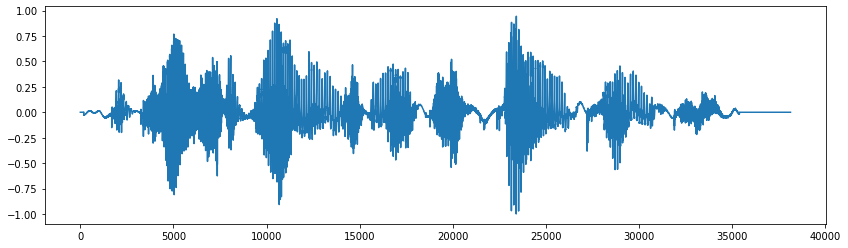

In [9]:
rate, s = wavfile.read('speech.wav')
# let's normalize the signal over the [-1, 1] interval
s = s / np.max(np.abs(s))
plt.plot(s);

Can we hear the effects of quantization? (Use headphones!)

In [10]:
IPython.display.Audio(s, rate=rate)

In [11]:
IPython.display.Audio(quantize(s, 127), rate=rate)

Indeed, the quantized version has a lower quality than the original but, as we will see, this is a small price to pay when we take the effects of the communication channel into account. 

Let's also compute for later the SNR for the audio quantized over 255 levels:

In [12]:
SNR(s, quantize(s, 127))

36.415461820105264

## 3. Transmission ##

Let's now define some functions that model the transmission of audio over a cable segment terminated by a repeater.

Each cable section will introduce attenuation and additive noise. The attenuation is specified in dB and the noise level is parametrized in terms of the signal to noise ratio at the end of the cable section. Remember that the SNR is defined as $10\log_{10}(\sigma_x^2 / \sigma_0^2)$, where $\sigma_x^2$ is the power of the signal and $\sigma_0^2$ the power of the noise. Since the amplitude of the signal at the end of the cable section will be attenuated, we take that into account to compute the amplitude of the noise.

We model the noise as a discrete-time white process where every sample is a random number drawn from a uniform distribution over the interval $[-A, A]$; the power of this signal is equal to the second moment of the distribution, namely, $\sigma_0^2 = A^2/3$.

In [13]:
def cable_section(x, att_db, snr_db):
    # amplitude attenuation from dB value
    att = 10 ** (-att_db / 20)    
    # noise amplitude from SNR at the end of the section
    A = att / (10 ** (snr_db / 20)) * np.sqrt(3)
    noise = np.random.uniform(-A, A, len(x))
    return x * att + noise

Let's check that the SNR is indeed close to the theoretical value; the difference is due to the fact that the input signal's energy is less than one:

In [35]:
SNR(x, cable_section(x, 0, 50))

47.09470350026929

The regenerating amplifier simply multiplies the input by the appropriate gain factor; here too we specify the gain in dB:

In [36]:
def repeater(x, gain_db):
    gain = 10 ** (gain_db / 20)
    return x * gain

Finally, for digital signals, the repeater will also perform signal *regeneration*: since the digital encoding only uses a fixed number of levels, which are known, the repeating amplifier can threshold the output signal and eliminate the additive noise (provided that the noise is not too large). Since this happens at each stage, even after several repeaters the trasmission will remain noise-free.

In [37]:
def regen(x, M):
    # to regenerate an M-level signal between -1 and 1, first map it to [-M, M]
    #  and then discard the fractional part
    return np.round(x * M) / M

### 3.1. One-stage example

Let's look at a simple example. Here we show the transmitted signal and the signal at the exit of the first repeater for analog transmission; as you can see the noise is amplified along with the signal:

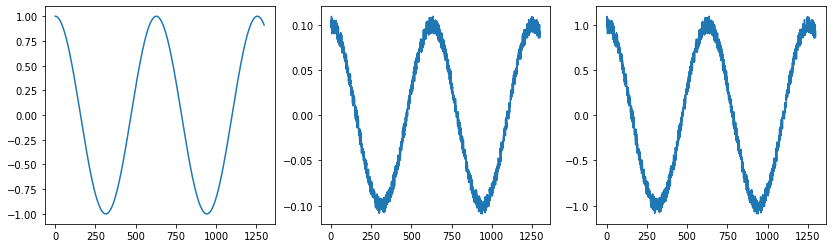

In [43]:
# simple signal
xa = np.cos(np.arange(0, 13, 0.01))

# 20 dB attenuation and a SNR of 25dB at the end of the section
ATT_DB, SRN_DB = 20, 25

# analog transmission
xa_t = cable_section(xa, ATT_DB, SRN_DB)
xa_r = repeater(xa_t, ATT_DB)
multiplot(xa, xa_t, xa_r)

Clearly the noise is preserved by the amplifier. Now let's see what happens with a digital encoding: although the signal is corrupted by noise, the repeater can regenerate it exactly:

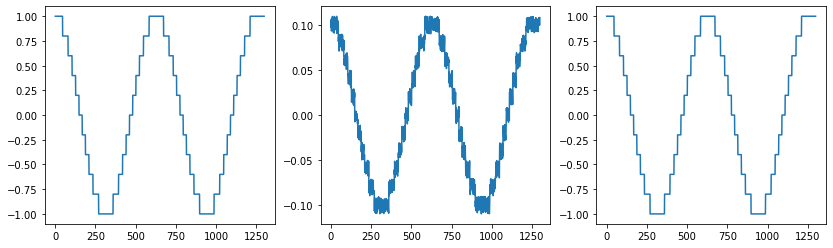

In [44]:
M = 5
xd = quantize(np.cos(np.arange(0, 13, 0.01)), M)
xd_t = cable_section(xd, ATT_DB, SRN_DB)
# regenerate after amplification
xd_r = regen(repeater(xd_t, ATT_DB), M)
multiplot(xd, xd_t, xd_r)

### 3.2. Multi-stage transmission

Let's now cascade several segments. First the analog transmission chain:

In [45]:
def analog_tx(x, num_repeaters, attenuation, noise_amplitude):
    for n in range(0, num_repeaters):
        x = repeater(cable_section(x, attenuation, noise_amplitude), attenuation)
    return x

and then the digital transmission chain, where we regenerate the signal after each repeater:

In [46]:
def digital_tx(x, num_repeaters, attenuation, noise_amplitude, levels=127):
    x = quantize(x, levels)
    for n in range(0, num_repeaters):
        x = regen(repeater(cable_section(x, attenuation, noise_amplitude), attenuation), levels)
    return x

Let's compare transmission schemes with some realistic values: we use about 100 amplifier as we would in a 3000Km cable, each with a 20dB attenuation/gain and each with a realistic SNR of 55dB:

In [59]:
NUM_REPEATERS = 100
ATT_SEC = 20
SNR_SEC = 55

ya = analog_tx(s, NUM_REPEATERS, ATT_SEC, SNR_SEC)
print ('Analog trasmission: SNR = %f dB' % SNR(s, ya))    

M = 127
yd = digital_tx(s, NUM_REPEATERS, ATT_SEC, SNR_SEC, M)
print ('Digital trasmission: SNR = %f dB' % SNR(s, yd))    

Analog trasmission: SNR = 18.219826 dB
Digital trasmission: SNR = 36.415462 dB


As you can see, while the analog transmission incurs a significant loss of quality, the SNR after digital transmission has not changed at all! And now this difference should be very easy to hear:

In [60]:
IPython.display.Audio(ya, rate=rate)

In [61]:
IPython.display.Audio(yd, rate=rate)

### 3.3. Effects of the noise

The signal regeneration mechanism will work only if the noise amplitude is smaller than the interval between quantization level. When this is not the case, the regenerator will make a mistake and these mistakes will introduce additional distortion which, ultimately, will negate the benefits of digital transmission.

For instance, if the noise is too large, the voice signal becomes completely unintelligible in both cases:

In [73]:
SNR_SEC_BAD = 40

ya = analog_tx(s, NUM_REPEATERS, ATT_SEC, SNR_SEC_BAD)
print ('Analog trasmission: SNR = %f dB' % SNR(s, ya))    

M = 127
yd = digital_tx(s, NUM_REPEATERS, ATT_SEC, SNR_SEC_BAD, M)
print ('Digital trasmission: SNR = %f dB' % SNR(s, yd))    

Analog trasmission: SNR = 3.168908 dB
Digital trasmission: SNR = 2.901995 dB


In [68]:
IPython.display.Audio(ya, rate=rate)

In [69]:
IPython.display.Audio(yd, rate=rate)

Note however that, in the case of digital transmission, we can reduce the number of quantization levels until the regenerator is again able to combat the noise. The resulting transmission SNR will be lower, but it will be lower in a *controlled* fashion, determined by the characteristic of the quantizer. For instance, using the settings above, we can reduce the number of levels to 14 and obtain the same SNR as for simple quantization:

In [71]:
M = 14
SNR(s, quantize(s, M))

17.272934280056717

In [72]:
yd = digital_tx(s, NUM_REPEATERS, ATT_SEC, SNR_SEC_BAD, M)
print ('Digital trasmission: SNR = %f dB' % SNR(s, yd))    

Digital trasmission: SNR = -9.307116 dB


The audio quality is not great but decidedly better than the one obtained by analog transmission:

In [29]:
IPython.display.Audio(yd, rate=rate)

In [30]:
IPython.display.Audio(ya, rate=rate)

# ---------------------------------




### Did you like this Notebook?
Yes, no, maybe? Why don't you give us some feedback using the completely anonymous form below? Thank you!

In [31]:
from IPython.display import IFrame
IFrame('https://www.surveymonkey.com/r/NOTOSURVEY?notebook_set=COM303&notebook_id=SignalTransmission', 600, 800)